# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
graph = uproot.open({file_path: "ticlNtuplizer/graph"})
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})

In [2]:
eid = 3

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
re = tracksters["raw_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [12]:
MAX_DISTANCE = 10       # cm
ENERGY_THRESHOLD = 10   # GeV

candidate_pairs = []
distances = []

# little -> big
inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        e_pair = (re[i], re[inner])
        if min(e_pair) < ENERGY_THRESHOLD and max(e_pair) > ENERGY_THRESHOLD:
            dst = euclidian_distance(clouds[i], clouds[inner])
            distances.append(dst)
            if dst <= MAX_DISTANCE:
                candidate_pairs.append((i, inner) if re[i] < re[inner] else (inner, i))
            
print("Candidate pairs:", len(candidate_pairs))
c_pairs = set(candidate_pairs)

Candidate pairs: 38


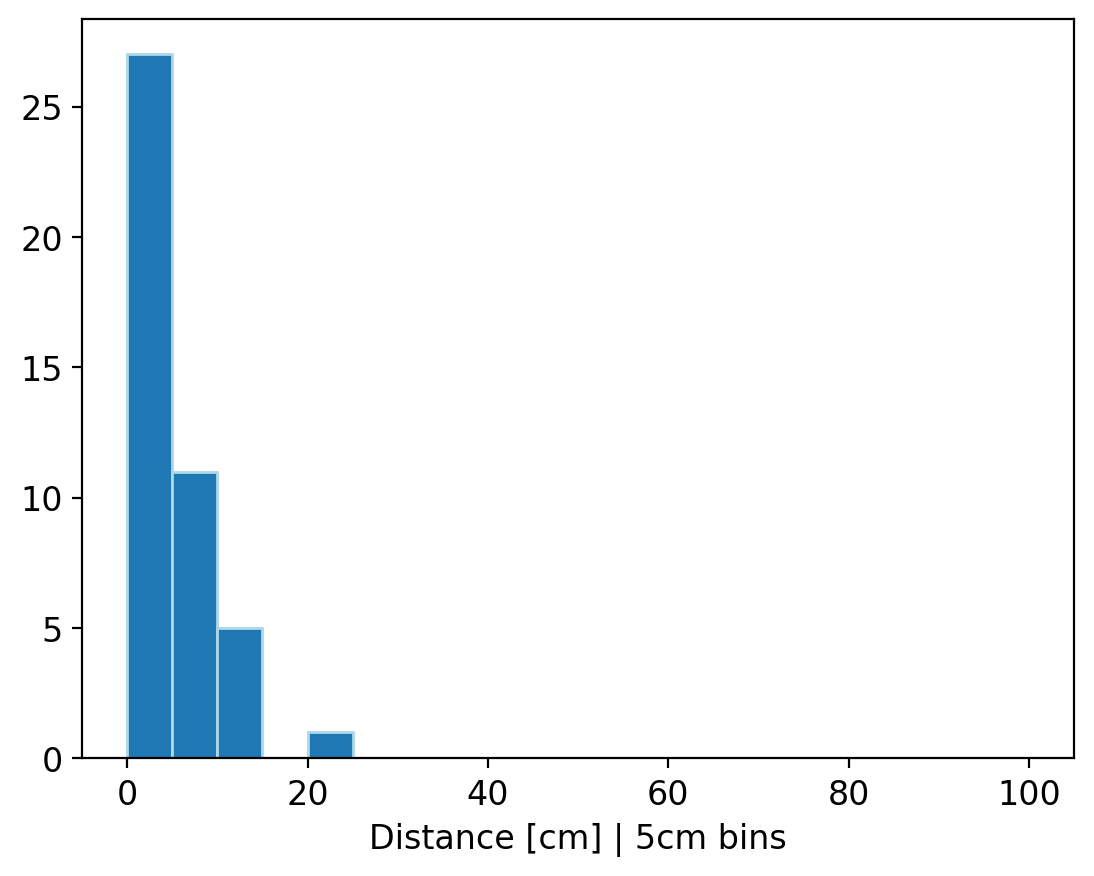

In [13]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

This is tricky:
- the ideal situation would be to always connect to the closest trackster of the same particle that is over 10GeV
- we could restrict the candidate pairs to only contain (little, big) combinations

Then two approaches are possible:
- construct the ground truth independently and look at the intersection with the candidate list
- or just evaluate whether two candidates come from the same particle (easier way?)

In [14]:
# ground truth approach
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=ENERGY_THRESHOLD,
    distance_threshold=MAX_DISTANCE,
    best_only=False, 
)

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])

gt_matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
gt_not_matches = c_pairs - gt_matches

print("Ground truth pairs:", len(gt_pairs), "matches:", len(gt_matches), "non-matches:", len(gt_not_matches))

Ground truth pairs: 57 matches: 36 non-matches: 2


In [15]:
%time _ = match_trackster_pairs(tracksters, simtracksters, associations, eid, energy_threshold=ENERGY_THRESHOLD, distance_threshold=MAX_DISTANCE, best_only=False)

CPU times: user 20 ms, sys: 1.85 ms, total: 21.9 ms
Wall time: 20.5 ms


In [16]:
# good pairs approach
c_matches = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.45)
c_not_matches = c_pairs - c_matches

print("matches:", len(c_matches), "non-matches:", len(c_not_matches))

matches: 38 non-matches: 0


In [17]:
%time _ = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.45)

CPU times: user 2.41 ms, sys: 35 µs, total: 2.45 ms
Wall time: 2.46 ms


In [18]:
# they do agree! (most of the time)
gt_matches.symmetric_difference(c_matches)
# find good pairs is faster so let's stick to it

{(13, 14), (13, 15)}

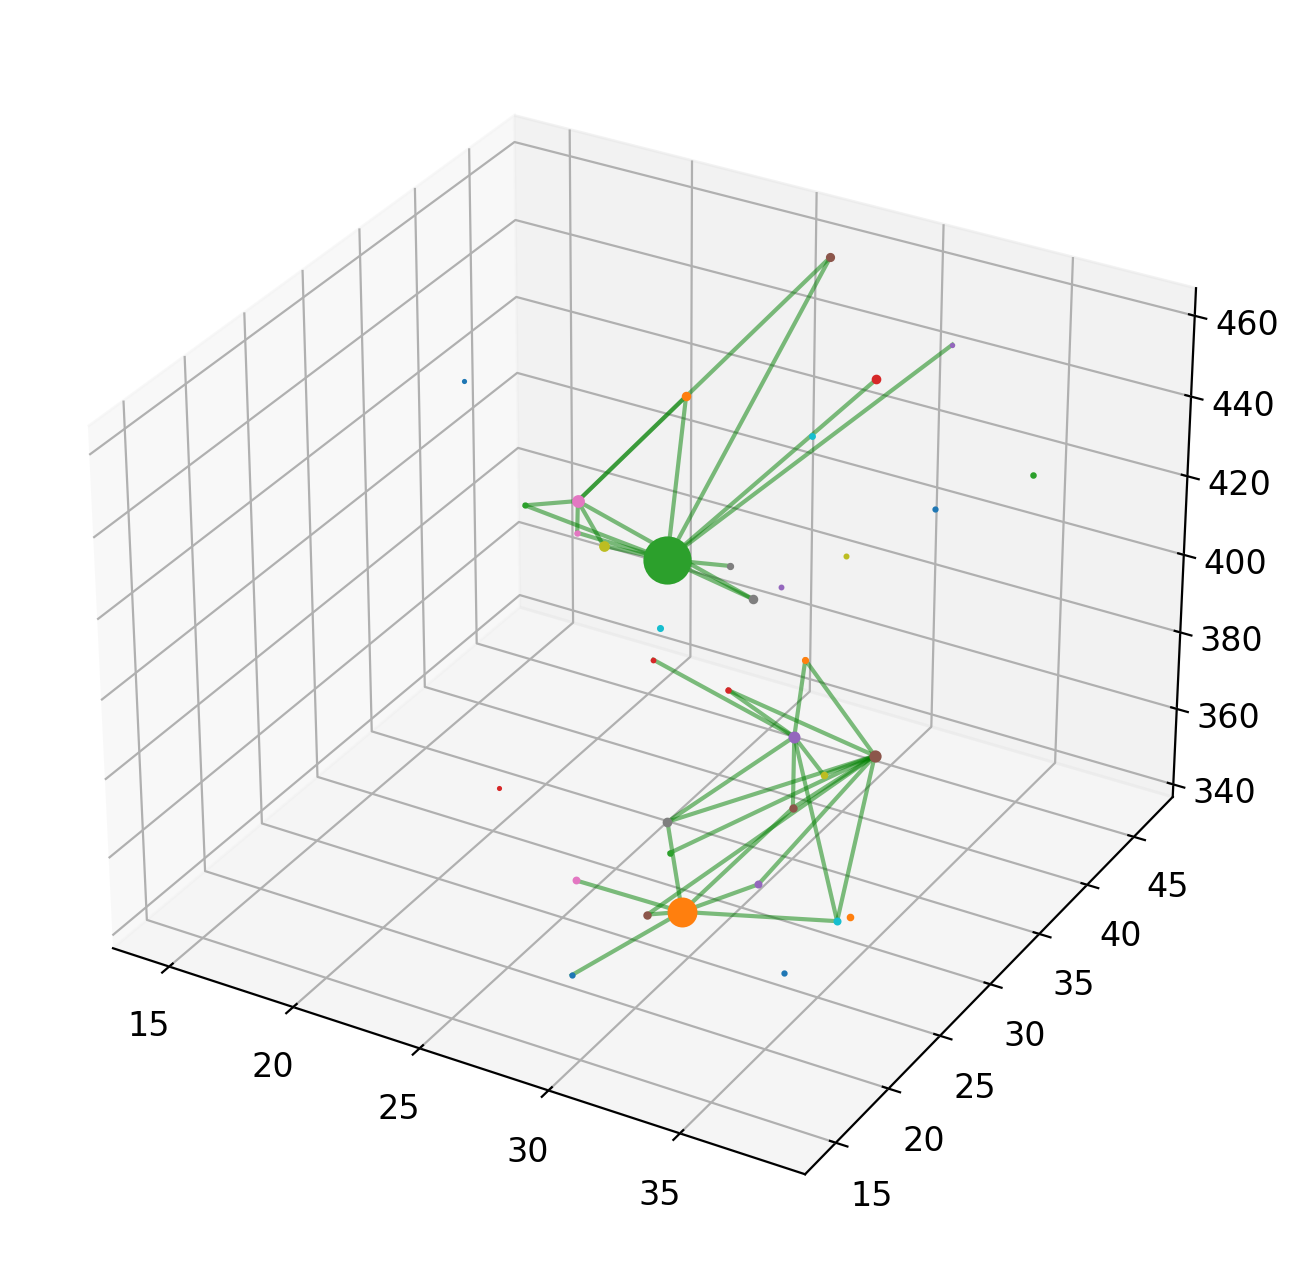

In [19]:
positive = list(c_matches)
negative = list(c_not_matches)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

bary = get_bary(tracksters, eid)

for i, tx in enumerate(bary):
    ax1.scatter(tx[0], tx[1], tx[2], s=re[i])

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax1, edge, "pink")
plt.show()

In [12]:
list(tracksters["raw_energy"].array()[3])

[1.594138741493225,
 95.57484436035156,
 1.8755015134811401,
 0.7254627346992493,
 3.5450565814971924,
 4.140832901000977,
 3.3445541858673096,
 6.219770431518555,
 2.970186948776245,
 3.5755460262298584,
 1.6080375909805298,
 3.001629114151001,
 267.1817321777344,
 1.7942314147949219,
 10.998977661132812,
 11.638620376586914,
 1.7197538614273071,
 5.905570983886719,
 1.3541370630264282,
 2.365485906600952,
 1.5512559413909912,
 2.453948974609375,
 1.5652422904968262,
 1.1544016599655151,
 1.2480069398880005,
 4.010493278503418,
 13.004798889160156,
 2.654108762741089,
 8.2310209274292,
 2.1799237728118896,
 0.7461768388748169,
 5.805156230926514,
 1.829491376876831,
 6.1404337882995605,
 0.8515299558639526,
 5.322925567626953]

## Dataset

In [2]:
from reco.datasetPU import TracksterPairsPU

In [3]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=2,
    radius=10
)
ds.processed_file_names

['TracksterPairs_CloseByTwoPion_f2_r10_s0.2.pt']

In [4]:
float(sum(ds.y) / len(ds.y))

0.9723843336105347

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [2]:
from reco.evaluation import pairwise_model_evaluation
from reco.dummy import DummyPleaser

In [4]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    clusters,
    DummyPleaser(),
    decision_th=0.98,
    radius=30,
    max_events=10,
    reco_to_target=False,
)

Event 0:
	clue3d_to_sim:	P: 0.97 R: 0.13 F: 0.16
	target_to_sim:	P: 0.81 R: 0.36 F: 0.40
	reco_to_sim:	P: 0.81 R: 0.39 F: 0.44
Event 1:
	clue3d_to_sim:	P: 1.00 R: 0.14 F: 0.17
	target_to_sim:	P: 0.97 R: 0.41 F: 0.46
	reco_to_sim:	P: 0.97 R: 0.41 F: 0.46
Event 2:
	clue3d_to_sim:	P: 1.00 R: 0.11 F: 0.13
	target_to_sim:	P: 0.93 R: 0.50 F: 0.55
	reco_to_sim:	P: 0.92 R: 0.52 F: 0.57
Event 3:
	clue3d_to_sim:	P: 0.98 R: 0.12 F: 0.14
	target_to_sim:	P: 0.63 R: 0.46 F: 0.49
	reco_to_sim:	P: 0.63 R: 0.49 F: 0.52
Event 4:
	clue3d_to_sim:	P: 0.99 R: 0.11 F: 0.14
	target_to_sim:	P: 0.86 R: 0.51 F: 0.55
	reco_to_sim:	P: 0.85 R: 0.52 F: 0.56
Event 5:
	clue3d_to_sim:	P: 0.98 R: 0.26 F: 0.30
	target_to_sim:	P: 0.77 R: 0.58 F: 0.61
	reco_to_sim:	P: 0.77 R: 0.60 F: 0.63
Event 6:
	clue3d_to_sim:	P: 0.98 R: 0.09 F: 0.11
	target_to_sim:	P: 0.86 R: 0.49 F: 0.53
	reco_to_sim:	P: 0.86 R: 0.49 F: 0.53
Event 7:
	clue3d_to_sim:	P: 0.91 R: 0.08 F: 0.09
	target_to_sim:	P: 0.91 R: 0.08 F: 0.09
	reco_to_sim:	P: 0.91 

# Problems

Sometimes - if a simtrackster is too fragmented, it might not get selected as a big trackster
- we score 0.2 and at least 50% shared energy (or 50GeV)
- if trackster is too fragmented, it might not pass -> then its layerclusters might get stolen
- otherwise: multiple options might pass and then we need to resolve conflicts